In [52]:
import numpy as np 
from numpy import random as rnd
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy import stats as stats
from scipy.special import factorial
import seaborn as sns
from itertools import product
import pandas as pd

## Point Process State Space Model 

We take the setting of a point process. Let the reward events $0 < u_1 < u_2 < ... < u_L$ be a realization from a point process with conditional intensity function $\lambda(u | H_u)$ where $u$ is a continuous-valued non-negative variable that denotes continuous time. N.B. we will use $t$ to denote a discrete time index. Let $N(u)$ be the associated counting process.

By definition of the CIF: 

$$P(N(u + \Delta) - N(u) = 1 | H_u ) \approx \lambda(u|H_u)\Delta + o(\Delta)  $$

s.t. with small enough discretization $\Delta$, $y_t \in \{0,1\}$

$$p(y_t | H_t) = (\lambda(t | H_t)\Delta)^y e^{-\lambda (t|H_t)\Delta}   $$


Then let $\lambda(t | \theta_t,H_t) = e^{\theta_t}$
We adopt a SRW on the dynamics of $\theta_t$ s.t. $\theta_t = \theta_{t-1} + \epsilon_{t}$ where $\epsilon_t \sim N(0,\sigma_\epsilon^2)$. This yields $\sigma_{t|t-1}^2 = \sigma_{t-1|t-1}^2 + \sigma_{\epsilon}^2 $

Solving the filtering equation, we arrive at: 

$$\theta_{t|t} = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - e^{\theta_{t|t-1}}\Delta ) = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - \lambda(t | \theta_{t},H_t)\Delta ) $$

$$\sigma_{t|t}^2 = \left(\lambda(t | \theta_{t-1},H_t)\Delta + \frac{1}{\sigma_{t|t-1}^2}   \right)^{-1} $$

We will initialize $\theta_{0|0}$ and $\sigma^2_{0|0}$ according to some prior distribution. (Gamma?)

In [115]:
def ppssm(y,theta_0,sigma2_0,sigma2_eps,dt = 0.05): 
    """ 
        Calculate estimated rate lambda and its variance 
        From a binary sequence y according to PPSSM filtering equations
    """
    seq_len = len(y)
    theta = np.concatenate((np.array([theta_0],dtype = np.float64),np.array(np.zeros(seq_len-1,dtype = np.float64))))
    sigma2 = np.concatenate((np.array([sigma2_0],dtype = np.float64),np.array(np.zeros(seq_len-1,dtype = np.float64))))
    for t in range(1,seq_len): 
        sigma2_given_tminus1 = sigma2[t-1] + sigma2_eps
        theta[t] = theta[t-1] + sigma2_given_tminus1 * (y[t] - dt*np.exp(theta[t-1]))
        sigma2[t] = np.min([10,(1 / (dt*np.exp(theta[t-1]) + 1/sigma2_given_tminus1))])
    return theta,sigma2

def stream_from_events(event_times,end_t,dt = 0.05): 
    """ 
        Convert event times into a binary stream of continuous data
    """ 
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    rew_stream[rew_ix] = 1
    return rew_stream

def stream_from_sized_events(event_times,event_sizes,end_t,dt = 0.05): 
    """
        Approximate rewards of varying sizes by using multiple positive events in a row
    """
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    for ix,dur in zip(rew_ix,event_sizes):
        rew_stream[ix:ix+dur] = 1
    return rew_stream

def cmap_lineplot(t,X,cmap,ax = None):  
    if ax: 
        for i in range(X.shape[0]): 
            ax.plot(t,X[i,:],c = cmap[i])
    else: 
        for i in range(X.shape[0]): 
            plt.plot(t,X[i,:],c = cmap[i])

In [116]:
end_t = 4 
dt = 0.05
t = np.arange(0,end_t,dt)
# Define a few trial types
r00 = stream_from_sized_events(np.array([0]),np.array([4]),end_t,dt = 0.05)
rr0 = stream_from_sized_events(np.array([0,1]),np.array([4,4]),end_t,dt = 0.05)
r0r = stream_from_sized_events(np.array([0,2]),np.array([4,4]),end_t,dt = 0.05)
rrr = stream_from_sized_events(np.array([0,1,2]),np.array([4,4,4]),end_t,dt = 0.05)

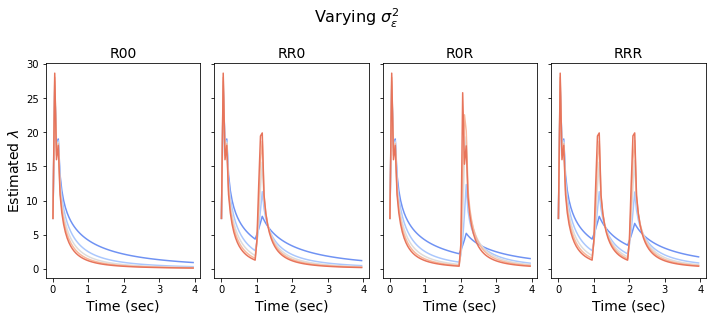

In [118]:
# Now vary sigma2_eps, estimate of process noise
n_param_tiles = 5
sigma2_eps_range = np.linspace(.01,.15,n_param_tiles)
r00_lam = np.zeros((n_param_tiles,len(r00)))
rr0_lam = np.zeros((n_param_tiles,len(r00)))
r0r_lam = np.zeros((n_param_tiles,len(r00)))
rrr_lam = np.zeros((n_param_tiles,len(r00)))
theta0 = 2
sigma2_0 = 2
for i,this_sigma2_eps in enumerate(sigma2_eps_range): 
    this_theta_r00,sigma = ppssm(r00,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_rr0,_ = ppssm(rr0,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_r0r,_ = ppssm(r0r,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_rrr,_ = ppssm(rrr,theta0,sigma2_0,this_sigma2_eps,dt)
    r00_lam[i,:] = np.exp(this_theta_r00)
    rr0_lam[i,:] = np.exp(this_theta_rr0)
    r0r_lam[i,:] = np.exp(this_theta_r0r)
    rrr_lam[i,:] = np.exp(this_theta_rrr)

fig3,ax = plt.subplots(1,4,figsize = (10,4),sharey = True)
cmap_lineplot(t,r00_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[0])
ax[0].set_title("R00",fontsize = 14,)
ax[0].set_xlabel("Time (sec)",fontsize = 14,)
ax[0].set_ylabel(r"Estimated $\lambda$",fontsize = 14,)
cmap_lineplot(t,rr0_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[1])
ax[1].set_title("RR0",fontsize = 14,)
ax[1].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,r0r_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[2])
ax[2].set_title("R0R",fontsize = 14,)
ax[2].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,rrr_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[3])
ax[3].set_title("RRR",fontsize = 14,)
ax[3].set_xlabel("Time (sec)",fontsize = 14,)
fig3.suptitle(r"Varying $\sigma^2_{\epsilon}$",fontsize = 16,y=1.1)
fig3.tight_layout()
plt.show()

## Now connect this more explicitly to the patch foraging task
Generate patch data according to task process and get behavior metrics on models

The session generation function: 

- Arguments: list of trial types, # trials per trial type
- Outputs: dictionary w/ trial type keys and $y$ streams from probabilistically chosen reward events
- Later can have this generate $y$ streams from behavior

The behavior function:

1) Run PPSM model over trials ($y$ made from stream_from_sized_events) and get running estimate of $\theta$ and $\sigma^2$ over time per trial

2) Map $\theta$ and $\sigma^2$ values into distributions over the value of $\lambda$ (lognormal!)

    a) Here, can make a visualization function to look at trials as heatmaps over posterior

3) Map lognormal distributions into $P(\lambda < \text{mean reward rate x})$

4) Map probabilities into behavior by applying a threshold $p_{threshold}$ __or__ stochastically generate behavior by running out processes per trial, where $p_{leave}(t) = P(\lambda(t) < \text{mean reward rate x})$

In [5]:
# session generation functions
def discrete_expo_pdf(N0,n_rew_locs = 20,tau = .125):
    """
        Assign reward delivery probabilities according to scaled Expo decay
    """
    x = np.arange(n_rew_locs)
    cdf = 1 - N0 * np.exp(-tau * x) / tau + N0 / tau
    pdf = cdf[1:] - cdf[:-1]
    return np.insert(pdf,0,1.) # add a deterministic reward at t = 0

def generate_session_y(rewsizes,N0s,n_trials_per_tt,end_t = 20,dt = 0.05): 
    """
        Arguments: list of reward sizes and N0 values and # trials per trial type
        Returns: y_tts_trials: dictionary with trial type keys and n_trials_per_tt streams of reward
            - y generated with stream_from_sized_events
    """
    # make PDFs
    pdfs_dict = {}
    for this_n0 in N0s: 
        pdfs_dict[this_n0] = discrete_expo_pdf(this_n0,n_rew_locs = end_t)
    
    # make trial reward streams
    y_tts_trials = {}
    tts = list(product(*[rewsizes,N0s]))
    for (this_rewsize,this_n0) in tts: 
        y_tts_trials[(this_rewsize,this_n0)] = np.empty_like([n_trials_per_tt],shape = (n_trials_per_tt,int(round(end_t/dt))))
        for i_trial in range(n_trials_per_tt): 
            trial_rewtimes = np.where(rnd.random(end_t) - pdfs_dict[this_n0] < 0)[0]
            y_trial = stream_from_sized_events(trial_rewtimes,np.full(len(trial_rewtimes),this_rewsize),end_t,dt)
            y_tts_trials[(this_rewsize,this_n0)][i_trial,:] = y_trial
    return y_tts_trials

def generate_from_rewtimes_y(rewsizes,rewseqs,end_t = 20,dt = 0.05): 
    """ 
        Arguments: dict of reward sizes,subplist of  reward time sequences 
        Returns: y_tts: list of y reward streams generated from stream_from_sized_events
    """
    y_tts = {}
    for this_rewsize in rewsizes: 
        y_tts[this_rewsize] = np.empty_like([n_trials_per_tt],shape = (len(rewseqs),int(round(end_t/dt))))
        for i,this_rewseq in enumerate(rewseqs): 
            y_tts[this_rewsize][i,:] = stream_from_sized_events(this_rewseq,np.full(len(this_rewseq),this_rewsize),end_t,dt)
    return y_tts

In [119]:
# generate session
rewsizes = [1,2,4]
N0s = [.125,.25,.5]
n_trials_per_tt = 100
dt = 0.050 # 50 ms
end_t = 10
y_tts_trials = generate_session_y(rewsizes,N0s,n_trials_per_tt,end_t = end_t)
theta0 = 5 # 1.5
sigma2_0 = .1 # .5
sigma2_eps = .04

# run PPSSM
ppssm_tts_trials = {}
for tt in y_tts_trials: 
    ppssm_tts_trials[tt] = []
    for y_trial in y_tts_trials[tt]:
        theta,sigma = ppssm(y_trial,tt[0],sigma2_0,sigma2_eps) # ppssm(y_trial,theta0,sigma2_0,sigma2_eps) # ppssm(y_trial,tt[0],sigma2_0,sigma2_eps)
        ppssm_tts_trials[tt].append((theta,sigma))
        

In [120]:
lognorm_cdf = lambda x,theta,sigma2: stats.lognorm.cdf(x,s = np.sqrt(sigma),scale = np.exp(theta))

# Analyze PPSSM results as probabilities 
def lamda_posterior_hmap(theta_trial,sigma2_trial,pdf_xvals): 
    """ 
        Given theta and sigma2 PPSSM estimates from a trial, return the lognormal posterior per timepoint
    """
    posterior = np.zeros((len(pdf_xvals),len(sigma2_trial)))
    for t in range(len(sigma2_trial)): 
        posterior[:,t] = stats.lognorm.pdf(pdf_xvals,s = np.sqrt(sigma2_trial[t]),scale = np.exp(theta_trial[t]))
    return posterior

def p_lessthan_x(ppssm_tts_trials,x): 
    """ 
        Given PPSSM results for a session, map trials into P(lambda < x) using the lognormal CDF
    """
    p_lessthan_tts_trials = {}
    for tt in ppssm_tts_trials.keys(): 
        p_lessthan_tts_trials[tt] = np.zeros((len(ppssm_tts_trials[tt]),len(ppssm_tts_trials[tt][0][0])))
        for i_trial in range(len(ppssm_tts_trials[tt])): 
            p_lessthan_tts_trials[tt][i_trial,:] = lognorm_cdf(x,ppssm_tts_trials[tt][i_trial][0],ppssm_tts_trials[tt][i_trial][1])
    return p_lessthan_tts_trials


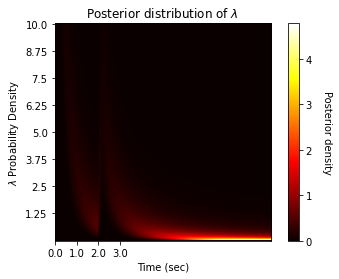

In [122]:
# Plot heatmap of posterior over lambda
pdf_xvals = np.linspace(0,10,200+1)
trial = 20
tt = (4,0.5)
posterior = lamda_posterior_hmap(ppssm_tts_trials[tt][trial][0],ppssm_tts_trials[tt][trial][1],pdf_xvals)
plt.title(r"Posterior distribution of $\lambda$")
plt.imshow(np.flipud(posterior),cmap = 'hot')
plt.ylabel(r"$\lambda$ Probability Density")
plt.yticks(np.arange(0,200,25),np.flipud(pdf_xvals[::25]))
plt.xlabel("Time (sec)")
plt.xticks(np.arange(0,len(t),20),np.arange(0,end_t,dt)[::20])
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel("Posterior density",rotation=-90)
plt.show()

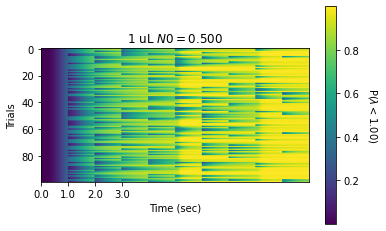

In [123]:
# Map distributions into CDF probabilities of being less than some (mean) rate
x = 1
tt = (1,.5)
p_lessthan_tts_trials = p_lessthan_x(ppssm_tts_trials,x)
plt.imshow(p_lessthan_tts_trials[tt])
plt.xlabel("Time (sec)")
plt.xticks(np.arange(0,len(t),20),np.arange(0,end_t,dt)[::20]);
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel(r"P($\lambda < %.2f$)"%x,rotation=-90)
plt.ylabel("Trials")
plt.title("%i uL $N0 = %.3f$"%(tt)) 
plt.show()


In [124]:
# Functions to map probabilities into behavior, taking P(lambda < x) as probability of leaving 
def stochastic_prt_gen(p_lessthan_tts_trials,prt_lock = None,dt = 0.05): 
    """ 
        Given p_lessthan_tts_trials, return stochastically generated patch residence times
        Using p_lessthan_tts_trials as p(leave)
        
        Add PRT lock to ensure that agent stays until x time
    """  
    prts = {}
    for i_tt,tt in enumerate(p_lessthan_tts_trials.keys()): 
        t_len = len(p_lessthan_tts_trials[tt][0])
        prts[tt] = np.zeros(len(p_lessthan_tts_trials[tt])) 
        for i_trial in range(len(prts[tt])): 
            leave_ix = np.where(rnd.random(t_len) - dt * p_lessthan_tts_trials[tt][i_trial] < 0)[0] 
            if prt_lock == None: 
                if len(leave_ix) > 0: 
                    prts[tt][i_trial] = dt * leave_ix[0]
                else: 
                    prts[tt][i_trial] = dt * t_len
            else: 
                if len(leave_ix) > 0: 
                    if len(leave_ix[leave_ix*dt > prt_lock[i_tt]]): # lock prt to min value per tt
                        prts[tt][i_trial] = dt * leave_ix[leave_ix*dt > prt_lock[i_tt]][0]
                    else: 
                        prts[tt][i_trial] = dt * t_len
                else: 
                    prts[tt][i_trial] = dt * t_len
    return prts


In [125]:
# Now generate PRT distributions
x = 1
p_lessthan_tts_trials = p_lessthan_x(ppssm_tts_trials,x)

In [126]:
prts = stochastic_prt_gen(p_lessthan_tts_trials)
prts_df = pd.DataFrame.from_dict(prts,orient = 'index').reset_index().melt(id_vars = 'index')
prts_df = prts_df.drop(['variable'],axis = 'columns')
prts_df = prts_df.rename(columns={"index": "tt", "value": "PRT"})

Text(0, 0.5, 'PRT (sec)')

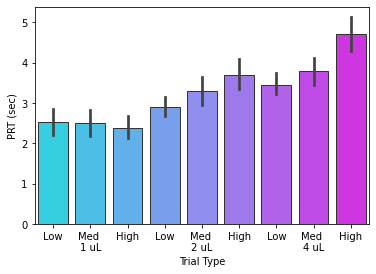

In [127]:
ax = sns.barplot(x="tt", y="PRT", data=prts_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["Low","Med \n1 uL","High"] + ["Low","Med \n2 uL","High"] + ["Low","Med \n4 uL","High"]) 
ax.set_xlabel("Trial Type") 
ax.set_ylabel("PRT (sec)")

In [128]:
# Now look into specific trial types
end_t = 8
rew_seqs = [np.array([0,1]),np.array([0,1,2])]
# create rxx trials, run PPSSM
y_rxx = generate_from_rewtimes_y([2,4],rew_seqs,end_t = end_t)
# run PPSSM
ppssm_rxx_tts = {}
for i_rewsize in y_rxx.keys(): 
    ppssm_rxx_tts[i_rewsize] = []
    for y_trial in y_rxx[i_rewsize]:
        theta,sigma = ppssm(y_trial,theta0,sigma2_0,sigma2_eps) # ppssm(y_trial,i_rewsize,sigma2_0,sigma2_eps)
        ppssm_rxx_tts[i_rewsize].append((theta,sigma))
ppssm_rxx_tts;

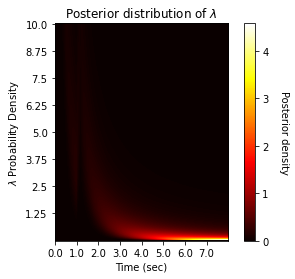

In [129]:
# Plot heatmap of posterior over lambda for RXX trial
pdf_xvals = np.linspace(0,10,200+1)
t = np.arange(0,end_t,dt)
rxx_tt = 0
i_rewsize = 4
posterior = lamda_posterior_hmap(ppssm_rxx_tts[i_rewsize][rxx_tt][0],ppssm_rxx_tts[i_rewsize][rxx_tt][1],pdf_xvals)
plt.title(r"Posterior distribution of $\lambda$")
plt.imshow(np.flipud(posterior),cmap = 'hot')
plt.ylabel(r"$\lambda$ Probability Density")
plt.yticks(np.arange(0,200,25),np.flipud(pdf_xvals[::25]))
plt.xlabel("Time (sec)")
plt.xticks(np.arange(0,len(t),20),np.arange(0,end_t,dt)[::20])
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel("Posterior density",rotation=-90)
plt.show()

In [130]:
def p_lessthan_x_rewseq(ppssm_tts,x,n_trials): 
    """ 
        Given PPSSM results for a session from reward sequences, map trials into P(lambda < x) using the lognormal CDF
        Tile with n_trials per trialtype to generate stochastic behavior 
    """
    p_lessthan_tts_trials = {}
    for (i_rewsize,i_rewseq) in list(product(list(ppssm_tts.keys()),np.arange(len(rew_seqs)))): # map into list of trialtypes
        this_cdf = lognorm_cdf(x,ppssm_tts[i_rewsize][i_rewseq][0],ppssm_tts[i_rewsize][i_rewseq][1])
        p_lessthan_tts_trials[(i_rewsize,i_rewseq)] = np.tile(this_cdf,(n_trials,1))
        
    return p_lessthan_tts_trials

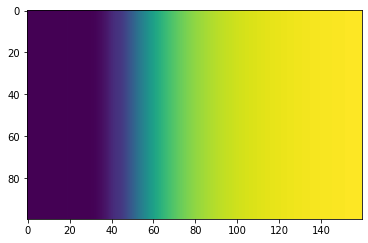

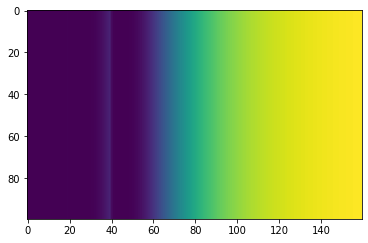

In [131]:
n_trials = 100
RXX_p_lessthan = p_lessthan_x_rewseq(ppssm_rxx_tts,x,n_trials)

plt.figure()
plt.imshow(RXX_p_lessthan[(4,0)])
plt.figure()
plt.imshow(RXX_p_lessthan[(4,1)])
plt.show()

In [132]:
# Generate stochastic behavior
prt_lock = 4 * [3]
prts = stochastic_prt_gen(RXX_p_lessthan,prt_lock = prt_lock)
prts_df = pd.DataFrame.from_dict(prts,orient = 'index').reset_index().melt(id_vars = 'index')
prts_df = prts_df.drop(['variable'],axis = 'columns')
prts_df = prts_df.rename(columns={"index": "tt", "value": "PRT"})


Text(0, 0.5, 'PRT (sec)')

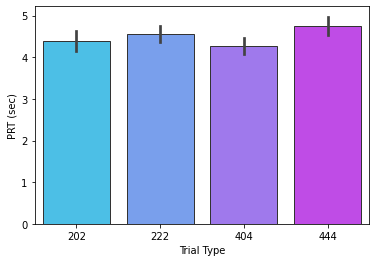

In [133]:
# visualize RXX behavior 
ax = sns.barplot(x="tt", y="PRT", data=prts_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["202","222"] + ["404","444"]) 
ax.set_xlabel("Trial Type") 
ax.set_ylabel("PRT (sec)")

In [134]:
# last, visualize dependence w/ time on patch
end_t = 8
rew_seqs = [np.array([0,1]),np.array([0,2]),np.array([0,2])]
# create rxx trials, run PPSSM
y_r2 = generate_from_rewtimes_y([2,4],rew_seqs,end_t = end_t)
# run PPSSM
ppssm_r2_tts = {}
for i_rewsize in y_r2.keys(): 
    ppssm_r2_tts[i_rewsize] = []
    for y_trial in y_r2[i_rewsize]:
        theta,sigma = ppssm(y_trial,1.5,sigma2_0,sigma2_eps) # ppssm(y_trial,i_rewsize,sigma2_0,sigma2_eps)
        ppssm_r2_tts[i_rewsize].append((theta,sigma))
ppssm_r2_tts; 

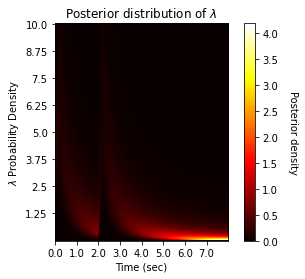

In [135]:
# Plot heatmap of posterior over lambda for r...r trials
pdf_xvals = np.linspace(0,10,200+1)
t = np.arange(0,end_t,dt)
r2_tt = 1
i_rewsize = 4
posterior = lamda_posterior_hmap(ppssm_r2_tts[i_rewsize][r2_tt][0],ppssm_r2_tts[i_rewsize][r2_tt][1],pdf_xvals)
plt.title(r"Posterior distribution of $\lambda$")
plt.imshow(np.flipud(posterior),cmap = 'hot')
plt.ylabel(r"$\lambda$ Probability Density")
plt.yticks(np.arange(0,200,25),np.flipud(pdf_xvals[::25]))
plt.xlabel("Time (sec)")
plt.xticks(np.arange(0,len(t),20),np.arange(0,end_t,dt)[::20])
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel("Posterior density",rotation=-90)
plt.show()

In [136]:
# generate r2 p_lessthan
n_trials = 100
prt_lock = 2 * [1,2,3]
r2_p_lessthan = p_lessthan_x_rewseq(ppssm_r2_tts,x,n_trials)

# Generate stochastic behavior
prts = stochastic_prt_gen(r2_p_lessthan,prt_lock = prt_lock)

for i_rewtime in [1,2,3]: 
    prts[(2,i_rewtime-1)] = prts[(2,i_rewtime-1)] - i_rewtime
    prts[(4,i_rewtime-1)] = prts[(4,i_rewtime-1)] - i_rewtime
    
prts_df = pd.DataFrame.from_dict(prts,orient = 'index').reset_index().melt(id_vars = 'index')
prts_df = prts_df.drop(['variable'],axis = 'columns')
prts_df = prts_df.rename(columns={"index": "tt", "value": "PRT"})
# prts

Text(0, 0.5, 'PRT After Last Reward (sec)')

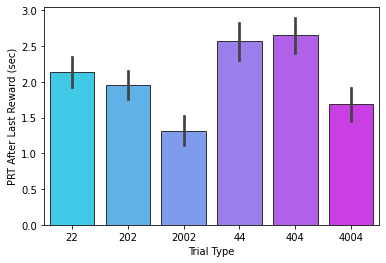

In [137]:
# visualize RXX behavior 
ax = sns.barplot(x="tt", y="PRT", data=prts_df,palette = 'cool',edgecolor="0.2")
ax.set_xticklabels(["22","202","2002"] + ["44","404","4004"]) 
ax.set_xlabel("Trial Type") 
ax.set_ylabel("PRT After Last Reward (sec)")

## Model based deep learning approach

We can get the PPSSM update equations to look something like a deep network as follows: 

$$\theta_{t|t} = \theta_{t|t-1} + \sigma^2_{t|t}(y_t - \Delta e^{\theta_{t|t-1}})  $$

$$\theta_{t|t} = \theta_{t|t-1} + (\sigma^2_{t|t-1}+\sigma^2_{\epsilon})(y_t - \Delta e^{\theta_{t|t-1}})  $$

$$\theta_{t|t} = (\theta_{t|t-1} - \Delta e^{\theta_{t|t-1}}) +  (\sigma^2_{t|t-1}+\sigma^2_{\epsilon}) y_t  $$

$$\theta_t = f(\theta_{t-1}) + g(y_t)  $$

Where $f$ is a nonlinear function of the previous state and $g$ is a linear function of the input and output of the parallel network

$$\sigma_{t|t}^2 = \left(\Delta e^{\theta_{t-1}} + \frac{1}{\sigma^2_{t|t-1}} \right)^{-1}$$

Which is a nonlinear function of previous state and output of the parallel network

In [91]:
# what is the true variance of a session? 
# A bit lower than what we are putting for sigma2_eps... can be explained by better prediction of 
y = []
for tt in y_tts_trials: 
    y.append(y_tts_trials[tt])
np.var(np.concatenate(y,axis = 1))

0.040759828117283944